In [1]:
!pip install --user uproot tqdm

In [2]:
username = "yian"
import getpass
import os
if os.system('klist | grep Default | grep ' + username + '@CERN.CH'):
    os.system('echo %s' % getpass.getpass() + " | kinit " + username)

Default principal: yian@CERN.CH


In [3]:
import uproot
import glob
import pandas as pd
from tqdm import tqdm

In [4]:
!pip install awkward

Defaulting to user installation because normal site-packages is not writeable


In [5]:
import numpy as np
import awkward as ak
import ROOT
import matplotlib.pyplot as plt

Welcome to JupyROOT 6.26/04


In [6]:
n_files = 20
root_files = glob.glob("/eos/user/y/yian/SWAN_projects/*.root")[:n_files]

In [11]:
f = uproot.open(root_files[0])
print(f.keys())
tree=f[f.keys()[1]]

['ntuplizer;1', 'ntuplizer/tree;1']


In [12]:
unneccesary_columns = ['ele_index',
       'Spring16GPV1Vals', 'Spring16GPV1RawVals', 'Spring16HZZV1Vals',
       'Spring16HZZV1RawVals', 'Fall17NoIsoV2Vals',
       'Fall17IsoV2Vals', 'Fall17IsoV1Vals',
       'Fall17NoIsoV1Vals', 'Spring16GPV1wp80', 'Spring16GPV1wp90',
       'Spring16HZZV1wpLoose', 'Fall17noIsoV2wp80', 'Fall17noIsoV2wpLoose',
       'Fall17noIsoV2wp90', 'Fall17isoV2wpHZZ', 'Fall17isoV2wp80',
       'Fall17isoV2wpLoose', 'Fall17isoV2wp90', 'Fall17noIsoV1wp90',
       'Fall17noIsoV1wp80', 'Fall17noIsoV1wpLoose', 'Fall17isoV1wp90',
       'Fall17isoV1wp80', 'Fall17isoV1wpLoose', 'nEvent', 'nRun', 'nLumi']

branch=tree.keys()
for c in unneccesary_columns:
    branch.remove(c)
print(len(branch))

62


In [13]:
f = uproot.lazy(root_files[0]+':ntuplizer/tree')

In [14]:
df=pd.DataFrame(np.array(f),columns=branch)

In [15]:
print(df)

       genNpu  vtxN  ele_q  ele_3q  matchedToGenEle        rho     ele_pt  \
0          70    55   -1.0       1                1  39.336685  75.166786   
1          70    55    1.0       1                1  39.336685  25.170097   
2          55    41    1.0       1                1  34.542377  40.437748   
3          55    41   -1.0       1                1  34.542377  39.272686   
4          65    54    1.0       1                1  28.301094  56.119308   
...       ...   ...    ...     ...              ...        ...        ...   
38613      63    53    1.0       0                1  43.432579  27.979042   
38614      63    53   -1.0       1                1  43.432579  26.223799   
38615      83    83    1.0       1                1  52.417740  23.142691   
38616      64    53   -1.0       1                2  49.768986  20.793974   
38617      64    53    1.0       1                0  49.768986  13.645608   

       ele_oldsigmaietaieta  ele_oldsigmaiphiiphi  ele_oldcircularity  ... 

In [16]:
import math
def get_df(root_file_name):        
    fin = uproot.lazy(root_file_name+':ntuplizer/tree')
    if len(fin) == 0:
        return pd.DataFrame()
    df=pd.DataFrame(np.array(fin),columns=branch)
    return df        

In [17]:
df = pd.concat((get_df(f1) for f1 in  tqdm(root_files)), ignore_index=True)

100%|██████████| 20/20 [00:14<00:00,  1.34it/s]


In [18]:
df.columns

Index(['genNpu', 'vtxN', 'ele_q', 'ele_3q', 'matchedToGenEle', 'rho', 'ele_pt',
       'ele_oldsigmaietaieta', 'ele_oldsigmaiphiiphi', 'ele_oldcircularity',
       'ele_oldr9', 'ele_scletawidth', 'ele_sclphiwidth', 'ele_hadronicOverEm',
       'ele_oldhe', 'ele_kfhits', 'ele_kfchi2', 'ele_gsfchi2', 'ele_fbrem',
       'ele_gsfhits', 'ele_expected_inner_hits',
       'ele_conversionVertexFitProbability', 'ele_ep', 'ele_eelepout',
       'ele_IoEmIop', 'ele_deltaetain', 'ele_deltaphiin', 'ele_deltaetaseed',
       'ele_psEoverEraw', 'ele_pfPhotonIso', 'ele_pfChargedHadIso',
       'ele_pfNeutralHadIso', 'scl_E', 'scl_Et', 'scl_eta', 'scl_phi',
       'ele_sclRawE', 'ele_sclNclus', 'ele_olde15', 'ele_olde25max',
       'ele_olde55', 'ele_ecalE', 'ele_ecalErr', 'ele_trackErr', 'ele_combErr',
       'ele_PFcombErr', 'ele_pfSumPUIso', 'ele_SCfbrem', 'ele_eClass',
       'ele_nbrem', 'ele_oldhebc', 'ele_hebc', 'ele_isEB', 'ele_isEE',
       'ele_isEBEtaGap', 'ele_isEBPhiGap', 'ele_isEBEEGap',

In [19]:
import matplotlib.pyplot as plt
import numpy as np

def get_label(name):
    if name == 0:
        return "background"
    else:
        return "signal"

def plot_electrons(df, column, bins, logscale=False, ax=None, title=None):
    if ax is None:
        ax = plt.gca()
    for name, group in df.groupby("matchedToGenEle"):
        group[column].hist(bins=bins, histtype="step", label=get_label(name), ax=ax, density=True)
    ax.set_ylabel("density")
    ax.set_xlabel(column)
    ax.legend()
    ax.set_title(title)
    if logscale:
        ax.set_yscale("log", nonposy='clip')

In [20]:
df = df.query("matchedToGenEle != 2")

In [21]:
df.loc[df["matchedToGenEle"] != 1, "matchedToGenEle"] = 0

In [22]:
df = df.query("abs(scl_eta) < 2.5")
df = df.query("ele_pt >= 10")

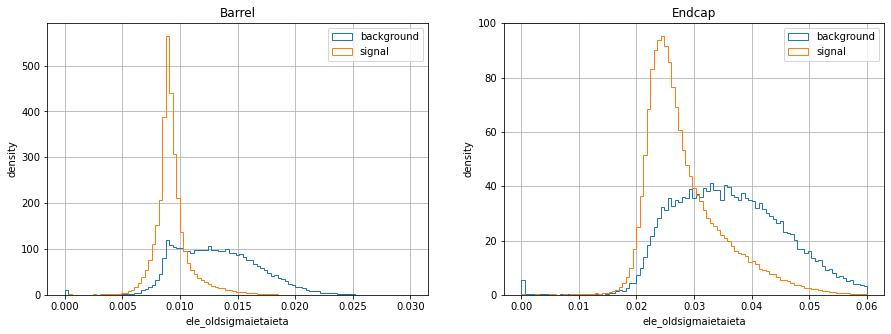

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plot_electrons(df.query("ele_isEB"), "ele_oldsigmaietaieta", np.linspace(0,0.03,100), ax=axes[0], title="Barrel")
plot_electrons(df.query("ele_isEE"), "ele_oldsigmaietaieta", np.linspace(0,0.06,100), ax=axes[1], title="Endcap")
plt.show()

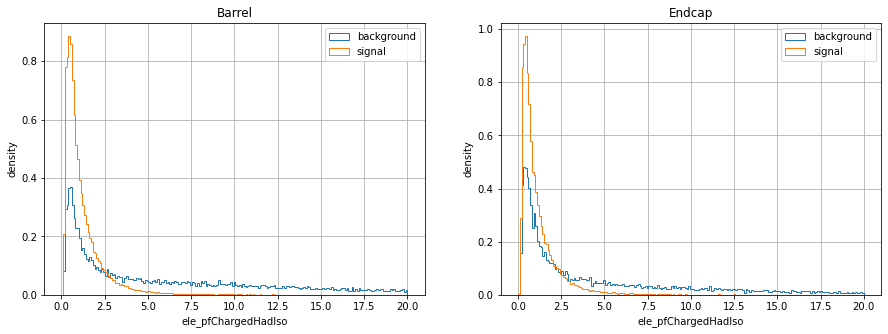

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plot_electrons(df.query("ele_isEB"), "ele_pfChargedHadIso", np.linspace(0.001,20,200), ax=axes[0], title="Barrel")
plot_electrons(df.query("ele_isEE"), "ele_pfChargedHadIso", np.linspace(0.001,20,200), ax=axes[1], title="Endcap")
plt.show()

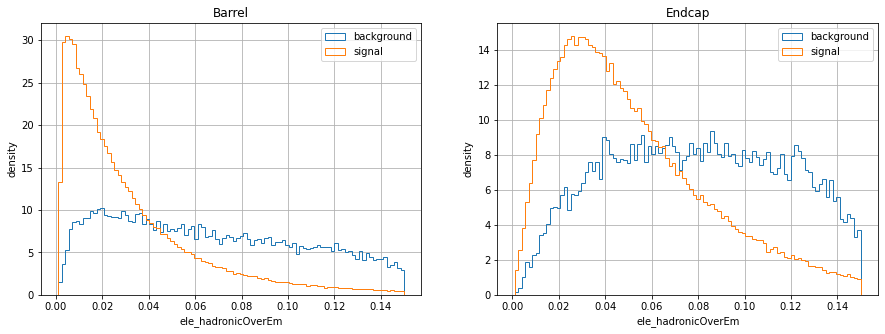

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plot_electrons(df.query("ele_isEB"), "ele_hadronicOverEm", np.linspace(0.001,0.15,100), ax=axes[0], title="Barrel")
plot_electrons(df.query("ele_isEE"), "ele_hadronicOverEm", np.linspace(0.001,0.15,100), ax=axes[1], title="Endcap")
plt.show()

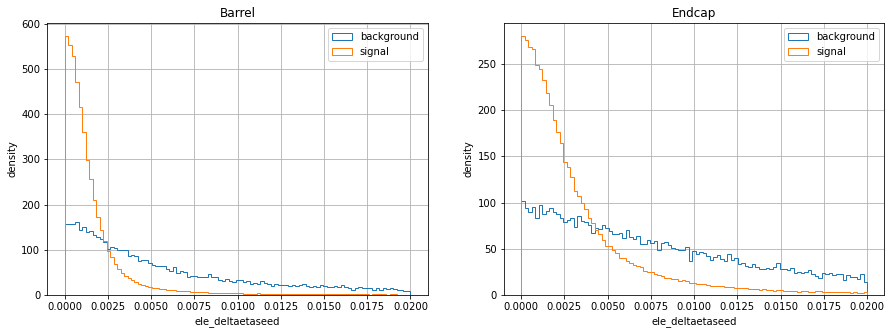

In [49]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plot_electrons(df.query("ele_isEB"), "ele_deltaetaseed", np.linspace(0,0.02,100), ax=axes[0], title="Barrel")
plot_electrons(df.query("ele_isEE"), "ele_deltaetaseed", np.linspace(0,0.02,100), ax=axes[1], title="Endcap")
plt.show()